In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings("ignore")


In [42]:
feature_extract_algo = 'sift'
feature_to_match = 'bf'

In [3]:
train_img = cv2.imread(r'C:\Users\ronjd\OneDrive\Desktop\project public repo\image stitching\unstitched\train.jpg')

#convert to bgr to rgb 
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
#convert to gray scale
train_gray = cv2.cvtColor(train_img, cv2.COLOR_RGB2GRAY)

query_img = cv2.imread(r'C:\Users\ronjd\OneDrive\Desktop\project public repo\image stitching\unstitched\query.jpg')
#convert to bgr to rgb
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
#convert to gray scale
query_gray = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)


Text(0.5, 0, 'trian image')

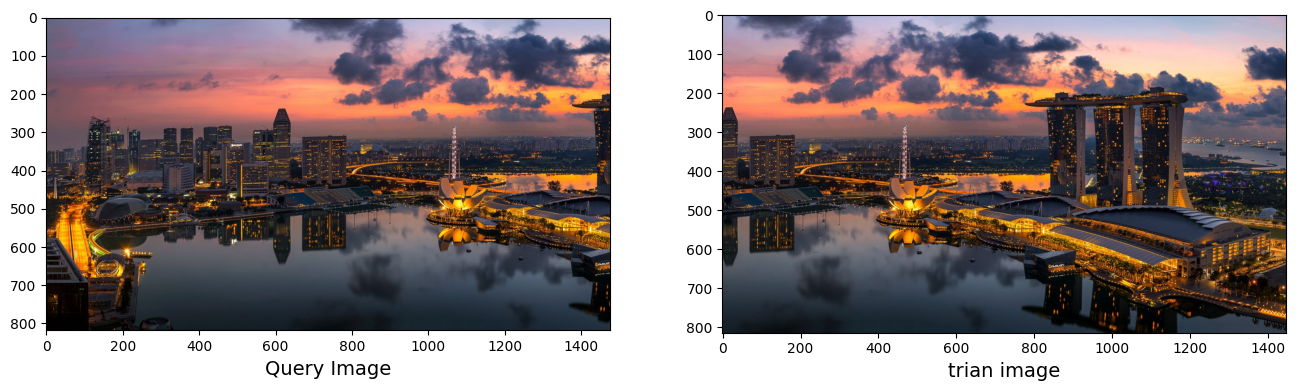

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = False, figsize=(16, 9))
ax1.imshow(query_img, cmap='gray')
ax1.set_xlabel('Query Image', fontsize=14)

ax2.imshow(train_img, cmap='gray')
ax2.set_xlabel('trian image', fontsize=14)

In [6]:
def detect_harris_keypoints(gray_img, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01):
    harris_response = cv2.cornerHarris(gray_img, block_size, ksize, k)
    harris_response = cv2.dilate(harris_response, None)

    threshold = threshold_ratio * harris_response.max()
    coords = np.argwhere(harris_response > threshold)  # (y, x) format
    keypoints = [cv2.KeyPoint(float(x), float(y), 3) for y, x in coords]
    return keypoints


In [17]:
def extract_patch_descriptors(gray_img, keypoints, patch_size):
    half = patch_size // 2
    descriptors = []

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if x - half < 0 or x + half >= gray_img.shape[1] or y - half < 0 or y + half >= gray_img.shape[0]:
            continue

        patch = gray_img[y - half:y + half + 1, x - half:x + half + 1].astype(np.float32)
        patch = patch.flatten()
        patch -= np.mean(patch)
        norm = np.linalg.norm(patch)
        if norm != 0:
            patch /= norm

        descriptors.append(patch)

    return np.array(descriptors)


In [18]:
query_kp = detect_harris_keypoints(query_gray)

for patch_size in [9, 11, 13]:
    descs = extract_patch_descriptors(query_gray, query_kp, patch_size)
    print(f"Patch size: {patch_size}, descriptors extracted: {descs.shape[0]}")



Patch size: 9, descriptors extracted: 66932
Patch size: 11, descriptors extracted: 66860
Patch size: 13, descriptors extracted: 66775


In [19]:
# Create SIFT object
sift = cv2.SIFT_create()

# Detect Harris points
query_harris_kp = detect_harris_keypoints(query_gray)
train_harris_kp = detect_harris_keypoints(train_gray)

# Compute SIFT descriptors at Harris keypoints
query_kp, query_desc = sift.compute(query_gray, query_harris_kp)
train_kp, train_desc = sift.compute(train_gray, train_harris_kp)

print("Query descriptors:", query_desc.shape)
print("Train descriptors:", train_desc.shape)




Query descriptors: (67244, 128)
Train descriptors: (74994, 128)


In [20]:
for keypoints in query_kp:
    x, y = keypoints.pt
    size = keypoints.size
    orientation = keypoints.angle
    response = keypoints.response
    octsave = keypoints.octave
    class_id = keypoints.class_id


print ("x,y:", x, y)
print ("size:", size)
print ("orientation:", orientation)
print ("response:", response)
print ("octave:", octsave)
print ("class_id:", class_id)

x,y: 181.0 818.0
size: 3.0
orientation: -1.0
response: 0.0
octave: 0
class_id: -1


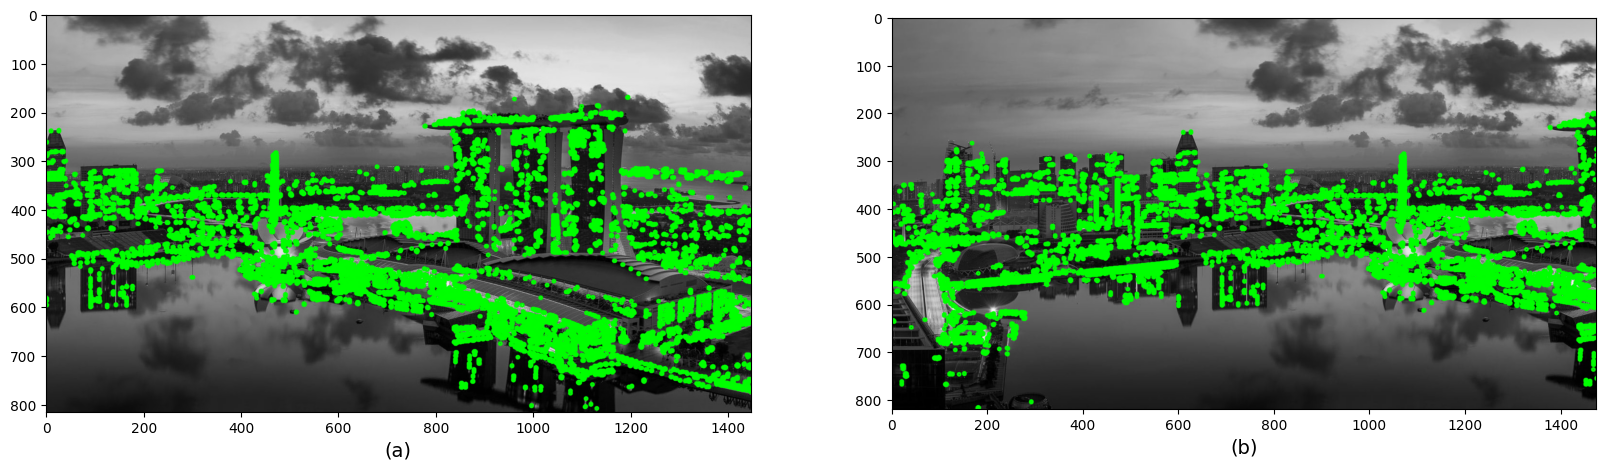

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = False, figsize=(20, 8))
ax1.imshow(cv2.drawKeypoints(train_gray,    train_kp, None, color=(0, 255, 0)))
ax1.set_xlabel('(a)', fontsize=14)
ax2.imshow(cv2.drawKeypoints(query_gray, query_kp, None, color=(0, 255, 0)))
ax2.set_xlabel('(b)', fontsize=14)

plt.show()



In [39]:
def create_matching(method, crossCheck):
    if method == 'sift':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    else:
        raise ValueError(f"Unsupported method: {method}. Only 'sift' is supported.")
    return bf

In [40]:
def key_point_matcher(train_desc,query_desc,method):
    bf=create_matching(method,crossCheck = True)

    best_matches=bf.match(train_desc,query_desc)

    raw_matches=sorted(best_matches,key=lambda x:x.distance)

    print("raw matches:", len(raw_matches))

    return raw_matches

Drawing matched descriptors... bf
raw matches: 38434


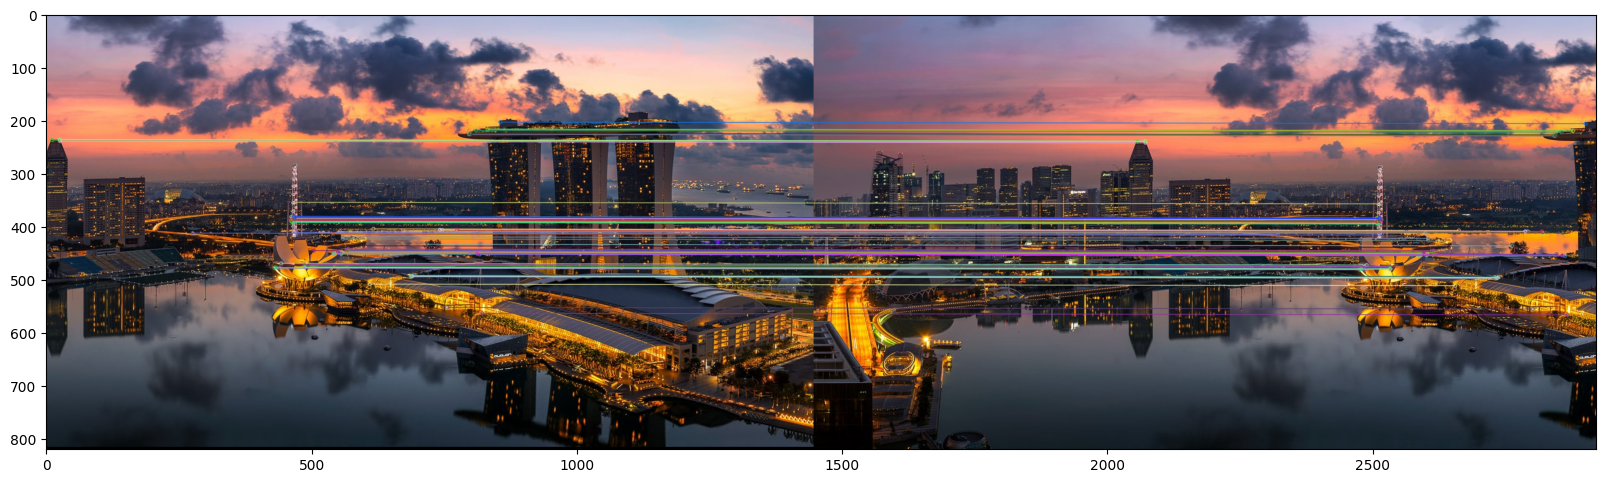

In [44]:


print("Drawing matched descriptors...", feature_to_match)

fig = plt.figure(figsize=(20, 8))

if feature_to_match == 'bf':
    matches = key_point_matcher(train_desc, query_desc, method=feature_extract_algo)  # Use the variable

    mapped_features_image = cv2.drawMatches(
        train_img, train_kp, query_img, query_kp, matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

plt.imshow(mapped_features_image)

In [47]:
def homography_stitching(train_kp, query_kp, matches, reprojTrhThresh):
    # Ensure train_kp and query_kp are lists of keypoints
    train_pts = np.float32([train_kp[m.queryIdx].pt for m in matches])  # Extract matched points from train_kp
    query_pts = np.float32([query_kp[m.trainIdx].pt for m in matches])  # Extract matched points from query_kp

    if len(matches) > 4:
        # Find homography matrix
        (H, status) = cv2.findHomography(train_pts, query_pts, cv2.RANSAC, reprojTrhThresh)
        return (matches, H, status)
    else:
        return None
  

In [48]:
M = homography_stitching(train_kp, query_kp, matches, reprojTrhThresh=4.0)
if M is None:
    print("Not enough matches to compute homography.")

(matches, H, status) = M

print("Homography matrix:\n", H)

Homography matrix:
 [[ 9.99999459e-01  2.11041762e-06  5.98999447e+02]
 [-5.37039815e-07  1.00000034e+00  3.00032694e+00]
 [-5.14529127e-10  1.05649195e-09  1.00000000e+00]]


In [49]:
width = query_img.shape[1] + train_img.shape[1]
print("width:", width)

width: 2922


In [51]:
height = max(query_img.shape[0], train_img.shape[0])  
print("height:", height)

height: 819


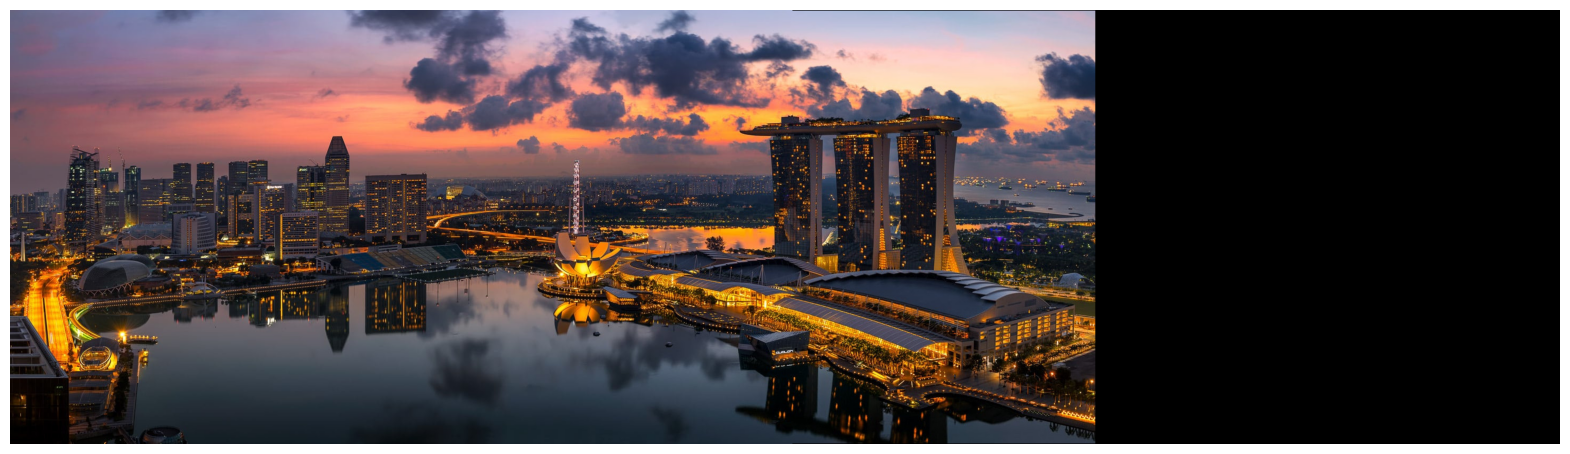

In [54]:
result =  cv2.warpPerspective(train_img, H, (width, height))
#print("result:", result)

result[0:query_img.shape[0], 0:query_img.shape[1]] = query_img

plt.figure(figsize=(20, 8))
plt.axis('off')
plt.imshow(result)